### Importation des bibliothèques

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import folium
from folium import plugins

### Loading Data and visualization

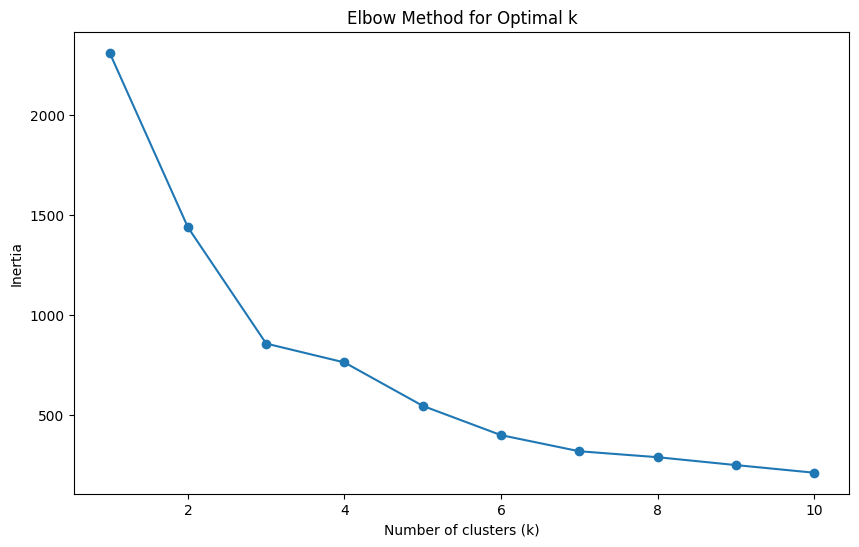

In [ ]:
data = pd.read_csv('whc-sites.csv')
df = pd.DataFrame(data)

# Select location features for clustering
X = df[['longitude', 'latitude']].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

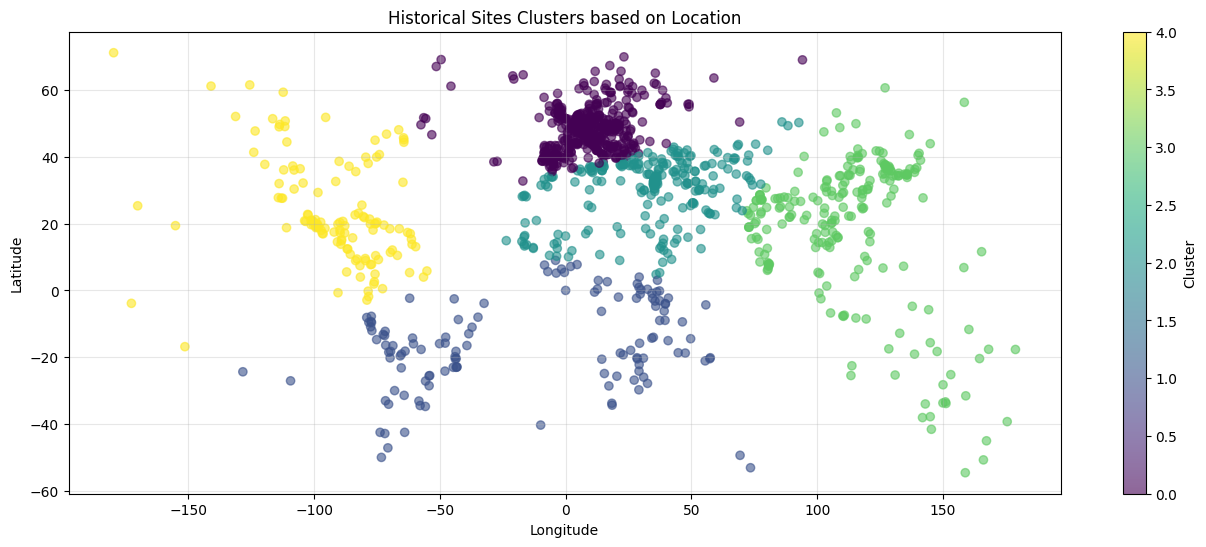


Cluster Summary:

Cluster 0:
Number of sites: 433
Average longitude: 9.42
Average latitude: 48.36
Most common regions: {'Europe and North America': 428, 'Arab States': 3}

Cluster 1:
Number of sites: 130
Average longitude: -14.04
Average latitude: -15.55
Most common regions: {'Africa': 64, 'Latin America and the Caribbean': 60}

Cluster 2:
Number of sites: 236
Average longitude: 33.22
Average latitude: 30.57
Most common regions: {'Arab States': 85, 'Europe and North America': 65}

Cluster 3:
Number of sites: 227
Average longitude: 112.85
Average latitude: 19.14
Most common regions: {'Asia and the Pacific': 221, 'Europe and North America': 5}

Cluster 4:
Number of sites: 129
Average longitude: -92.20
Average latitude: 23.34
Most common regions: {'Latin America and the Caribbean': 86, 'Europe and North America': 42}


In [ ]:
# Perform K-means clustering with optimal k (let's use k=5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters on a scatter plot
plt.figure(figsize=(16, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], 
                     c=df['Cluster'], cmap='viridis',
                     alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Historical Sites Clusters based on Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary of clusters
print('\nCluster Summary:')
for i in range(n_clusters):
    cluster_sites = df[df['Cluster'] == i]
    print(f'\nCluster {i}:')
    print(f'Number of sites: {len(cluster_sites)}')
    print(f'Average longitude: {cluster_sites["longitude"].mean():.2f}')
    print(f'Average latitude: {cluster_sites["latitude"].mean():.2f}')
    print('Most common regions:', cluster_sites['Region'].value_counts().head(2).to_dict())

### Interactive Map Visualization of Clusters

In [ ]:
# Calculate the center point for the map
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

# Create a base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=1)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Add markers for each site
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=row['Name'],
        color=colors[row['Cluster']],
        fill=True
    ).add_to(m)

# Add a legend
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">&nbsp; <b>Clusters</b> <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i>&nbsp; Cluster 0 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i>&nbsp; Cluster 1<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>&nbsp; Cluster 2<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:purple"></i>&nbsp; Cluster 3<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i>&nbsp; Cluster 4
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

### Enhanced Interactive Map with Detailed Information

In [ ]:
# Create an enhanced map with more detailed information
enhanced_map = folium.Map(location=[center_lat, center_lon], zoom_start=2,
                         tiles='CartoDB positron',
                         width=800,  # Set specific width in pixels
                         height=600)  # Set specific height in pixels

# Create a MarkerCluster for better visualization when zoomed out
marker_cluster = plugins.MarkerCluster().add_to(enhanced_map)

# Add markers for each site with detailed popups
for idx, row in df.iterrows():
    # Create detailed HTML popup content
    popup_content = f'''
        <div style='width: 300px'>
            <h4>{row['Name']}</h4>
            <p><b>Category:</b> {row['category_long']}</p>
            <p><b>Country:</b> {row['Country name']}</p>
            <p><b>Region:</b> {row['Region']}</p>
            <p><b>Inscription Date:</b> {row['date_inscribed']}</p>
            <p><b>Cluster:</b> {row['Cluster']}</p>
            <hr>
            {row['short_description']}
        </div>
    '''

    # Create circle marker with custom style
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=folium.Popup(popup_content, max_width=300),
        color=colors[row['Cluster']],
        fill=True,
        fill_opacity=0.7,
        weight=2
    ).add_to(marker_cluster)

# Add a fullscreen button
plugins.Fullscreen().add_to(enhanced_map)

# Add a minimap
minimap = plugins.MiniMap(toggle_display=True)
enhanced_map.add_child(minimap)

# Add layer control
folium.LayerControl().add_to(enhanced_map)

# Add the legend with improved styling
legend_html = '''
<div style='position: fixed; 
            bottom: 50px; left: 50px; width: 200px;
            border:2px solid grey; z-index:9999;
            font-size:14px; background-color:white;
            padding: 10px;
            border-radius: 5px;
            box-shadow: 0 0 15px rgba(0,0,0,0.2);'>
    <div style='text-align:center;'><b>UNESCO Sites Clusters</b></div>
    <hr style='margin:5px;'>'''

for i, color in enumerate(colors):
    cluster_count = len(df[df['Cluster'] == i])
    legend_html += f'''
    <div style='margin-bottom:5px;'>
        <i class='fa fa-circle fa-1x' style='color:{color}'></i>
        Cluster {i} ({cluster_count} sites)
    </div>
    '''

legend_html += '</div>'
enhanced_map.get_root().html.add_child(folium.Element(legend_html))

# Add title with adjusted positioning
title_html = '''
    <div style='position: absolute; 
                top: 10px; left: 50%; transform: translateX(-50%);
                z-index:9999; font-size:24px; font-weight: bold;
                background-color: white; padding: 10px;
                border-radius: 5px; box-shadow: 0 0 15px rgba(0,0,0,0.2);'>
        UNESCO World Heritage Sites Clusters
    </div>
'''
enhanced_map.get_root().html.add_child(folium.Element(title_html))

# Add CSS to center the map and control its size
css = '''
<style>
    .folium-map {
        margin: 0 auto;
    }
</style>
'''
enhanced_map.get_root().html.add_child(folium.Element(css))

# Display the map
enhanced_map

In [13]:
# Export the enhanced map to HTML
output_file = 'unesco_heritage_sites_clusters.html'
enhanced_map.save(output_file)

print(f'Map has been exported to {output_file}')

# Print cluster statistics
print('\nCluster Statistics:')
for i in range(n_clusters):
    cluster_sites = df[df['Cluster'] == i]
    print(f'\nCluster {i}:')
    print(f'Number of sites: {len(cluster_sites)}')
    print('Top 3 regions:')
    print(cluster_sites['Region'].value_counts().head(3))
    print('Top 3 categories:')
    print(cluster_sites['category_long'].value_counts().head(3))
    print(f'Average latitude: {cluster_sites["latitude"].mean():.2f}')
    print(f'Average longitude: {cluster_sites["longitude"].mean():.2f}')

Map has been exported to unesco_heritage_sites_clusters.html

Cluster Statistics:

Cluster 0:
Number of sites: 433
Top 3 regions:
Region
Europe and North America    428
Arab States                   3
Asia and the Pacific          1
Name: count, dtype: int64
Top 3 categories:
category_long
Cultural    393
Natural      33
Mixed         7
Name: count, dtype: int64
Average latitude: 48.36
Average longitude: 9.42

Cluster 1:
Number of sites: 130
Top 3 regions:
Region
Africa                             64
Latin America and the Caribbean    60
Europe and North America            5
Name: count, dtype: int64
Top 3 categories:
category_long
Cultural    71
Natural     53
Mixed        6
Name: count, dtype: int64
Average latitude: -15.55
Average longitude: -14.04

Cluster 2:
Number of sites: 236
Top 3 regions:
Region
Arab States                 85
Europe and North America    65
Asia and the Pacific        51
Name: count, dtype: int64
Top 3 categories:
category_long
Cultural    205
Natural      24


In [ ]:
legend_html = '''
<div style='position: fixed; 
            bottom: 50px; left: 50px; width: 200px;
            border:2px solid grey; z-index:9999;
            font-size:14px; background-color:white;
            padding: 10px;
            border-radius: 5px;
            box-shadow: 0 0 15px rgba(0,0,0,0.2);'>
    <div style='text-align:center;'><b>UNESCO Sites Clusters</b></div>
    <hr style='margin:5px;'>'''

for i, color in enumerate(colors):
    cluster_count = len(df[df['Cluster'] == i])
    legend_html += f'''
    <div style='margin-bottom:5px;'>
        <i class='fa fa-circle fa-1x' style='color:{color}'></i>
        Cluster {i} ({cluster_count} sites)
    </div>
    '''

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))
m.get_root().html.add_child(folium.Element(css))
output_file = 'map_heritage.html'
m.save(output_file)
m